## Import Libs

In [ ]:
# import os
import pandas as pd
import numpy as np
import datetime as dt
import logging
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from torch import optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from torch.optim import AdamW
from utils import SklearnWrapper

In [ ]:
from config import *
from entities import *
from components import *
from strategies import *
from datasets import *
from engine import Engine
from models import DiffusionTransformer
from frameworks import Diffusion

## Setting 

In [ ]:
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

## Data

### Load Data to basket

In [ ]:
symbols = ['AAPL', 'TSLA', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'GOOG', 'META', 'AVGO', 'ORCL', 'CRM', 'ADBE', 'AMD', 'CSCO']
basket = Basket(symbols=symbols)
basket.load_all_assets(freq="1d")

### Norm To Returns

In [5]:
targets = ["Close"]
for symbol, asset in basket.assets.items():
    asset.to_returns(log=True, columns=targets)
asset.data.head(5)

DEBUG:entities.asset:AAPL converted to Returns (log=True)
DEBUG:entities.asset:TSLA converted to Returns (log=True)
DEBUG:entities.asset:MSFT converted to Returns (log=True)


,High,Low,Open,Close (Log_Returns),Volume (Log_Returns)
Date,,,,,
2015-01-05,39.907440,39.497520,39.599999,-0.009238,0.351569
2015-01-06,39.924502,38.891163,39.608523,-0.014787,-0.084810
2015-01-07,39.676854,38.848476,39.266934,0.012626,-0.224661
2015-01-08,40.778520,39.898901,39.924520,0.028994,0.018078
2015-01-09,40.838295,40.052616,40.658956,-0.008441,-0.213574


### Align Data (Joint Data)

In [6]:
strategy = IntersectionStrategy()
joint_df = basket.align(strategy)
joint_df.head()

DEBUG:strategies.concrete:Intersection Strategy: Aligned 3 assets. Common rows: 2723
DEBUG:entities.basket:Aligned data shape: (2723, 15)
INFO:entities.basket:Assets updated in-place to aligned index (Length: 2723)


AAPL                                            \
                 High        Low       Open Close (Log_Returns)   
Date                                                              
2015-01-05  24.110150  23.391173  24.030263           -0.028576   
2015-01-06  23.839424  23.218085  23.641928            0.000094   
2015-01-07  24.010290  23.677430  23.788384            0.013925   
2015-01-08  24.886815  24.121236  24.238848            0.037702   
2015-01-09  25.130917  24.456320  25.002210            0.001072   

                                      TSLA                        \
           Volume (Log_Returns)       High        Low       Open   
Date                                                               
2015-01-05             0.189189  14.433333  13.810667  14.303333   
2015-01-06             0.023242  14.280000  13.614000  14.004000   
2015-01-07            -0.495052  14.318667  13.985333  14.223333   
2015-01-08             0.392173  14.253333  14.000667  14.187333   
2015-01-09            -0.100293  13.998667  13.664000  13.928000   

                                                          MSFT             \
           Close (Log_Returns) Volume (Log_Returns)       High        Low   
Date                                                                        
2015-01-05           -0.042950             0.119377  39.907440  39.497520   
2015-01-06            0.005648             0.153935  39.924502  38.891163   
2015-01-07           -0.001563            -0.746461  39.676854  38.848476   
2015-01-08           -0.001566             0.148175  40.778520  39.898901   
2015-01-09           -0.018981             0.304597  40.838295  40.052616   

                                                                
                 Open Close (Log_Returns) Volume (Log_Returns)  
Date                                                            
2015-01-05  39.599999           -0.009238             0.351569  
2015-01-06  39.608523           -0.014787            -0.084810  
2015-01-07  39.266934            0.012626            -0.224661  
2015-01-08  39.924520            0.028994             0.018078  
2015-01-09  40.658956           -0.008441            -0.213574

In [7]:
features = ["Close (Log_Returns)"]
basket_tensor = basket.to_tensor(features=features)
basket_tensor.shape

DEBUG:entities.asset:Asset: AAPL is using cuda device.
DEBUG:entities.asset:Asset: TSLA is using cuda device.
DEBUG:entities.asset:Asset: MSFT is using cuda device.


torch.Size([2723, 3, 2])

In [8]:
def verify_scaling(t: torch.Tensor):
    print(f"Max: {t.max().item():.4f}")
    print(f"Min: {t.min().item():.4f}")
    print(f"Mean: {t.mean().item():.4f}")
    print(f"Std: {t.std().item():.4f}")

verify_scaling(basket_tensor)

Max: 1.8823
Min: -1.7725
Mean: 0.0005
Std: 0.2279


#### Market Setup & Window Rolling Setup

In [9]:
window = RollingWindow(size=64, stride=1)
market = Market(basket, window)
market_tensor = market.setup(features=features)

INFO:entities.market:Setting up Market environment
DEBUG:entities.asset:Asset: AAPL is using cuda device.
DEBUG:entities.asset:Asset: TSLA is using cuda device.
DEBUG:entities.asset:Asset: MSFT is using cuda device.
DEBUG:components.windowing:RollingWindow applied. Result: torch.Size([2660, 64, 3, 2])
INFO:entities.market:Market Setup Complete. Batch Shape: torch.Size([2660, 64, 3, 2]) [B, L, N, F]


In [10]:
print(f"Market Tensor Shape: {market_tensor.shape}")
verify_scaling(market_tensor)

Market Tensor Shape: torch.Size([2660, 64, 3, 2])
Max: 1.8823
Min: -1.7725
Mean: 0.0004
Std: 0.2277


### Scaler

In [11]:
sklearn_scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = SklearnWrapper(sklearn_scaler)

scaler.fit(market_tensor)
norm_data = scaler.encode(market_tensor)

print(f"Norm data shape: {market_tensor.shape}")
print(f"Data {market_tensor[0,0,0,:]}")
verify_scaling(norm_data)

DEBUG:utils.scaler:Scaler Fitted using: MinMaxScaler


Norm data shape: torch.Size([2660, 64, 3, 2])
Data tensor([-0.0286,  0.1892], device='cuda:0')
Max: 1.0000
Min: -1.0000
Mean: 0.0235
Std: 0.1582


### Dataloader & Datasets

In [12]:
modes = ["exhaustive", "random"]
market_ds = JointMarketDataset(norm_data)

print(f"Norm Data: {norm_data.shape}")
print(f"Market Dataset: {len(market_ds)}")

# market_ds = MarketDataset(norm_data, mode='random')
ratios = [0.8, 0.1, 0.1]
train_ds, val_ds, test_ds = create_randomize_datasets(market_ds, ratios)

print(f"Train samples: {len(train_ds)}")
print(f"Val samples: {len(val_ds)}") 
print(f"Test samples: {len(test_ds)}")

Norm Data: torch.Size([2660, 64, 3, 2])
Market Dataset: 2660
Train samples: 2128
Val samples: 266
Test samples: 266


In [13]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=True)

In [14]:
x = next(iter(train_loader))
print(f"x shape: {x.shape}")
verify_scaling(x)

x shape: torch.Size([32, 64, 3, 2])
Max: 0.8292
Min: -0.6060
Mean: 0.0233
Std: 0.1646


## Model

### Setup

In [15]:
cfg = TrainConfig(
    epochs=1000,
    optimizer=OptimizerConfig(lr=2e-4)
)

print(cfg.optimizer.lr) 
print(cfg.epochs)    
print(cfg.ddpm)

0.0002
1000
DDPMConfig(noise_steps=1000, beta_start=0.0001, beta_end=0.02, schedule='cosine', d_model=128, n_heads=4, n_layers=4, max_t=128)


In [16]:
WINDOW_SIZE = x.shape[1]       # T
NUM_ASSETS = x.shape[2]         # N
NUM_FEATURES = x.shape[3]      # F
TOTAL_INPUT_DIM = NUM_ASSETS * NUM_FEATURES # C = N * F (Flatten)

print(f"Running on: {cfg.device}")
print(f"Input Dimension (Channels): {TOTAL_INPUT_DIM}")

Running on: cuda
Input Dimension (Channels): 6


### Diffusion

In [17]:
diffusion = Diffusion(
    noise_steps=cfg.ddpm.noise_steps,
    beta_start=cfg.ddpm.beta_start,
    beta_end=cfg.ddpm.beta_end,
    schedule=cfg.scheduler.type,
    device=cfg.device
)

DEBUG:frameworks.ddpm:Diffusion is using cosine schedule.


### NN Model

In [18]:
model = DiffusionTransformer(
    features_in=TOTAL_INPUT_DIM,  # รับ Input ขนาด N*F
    d_model=cfg.ddpm.d_model,                  # ความกว้าง Model
    nhead=cfg.ddpm.n_heads,
    num_layers=cfg.ddpm.n_layers,
    max_len=WINDOW_SIZE           # รองรับความยาวสูงสุดเท่า Window
).to(cfg.device)

/home/narodom.y@FUSION.LAB/.conda/envs/tsgenai/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


### Optimizer

In [19]:
optimizer = AdamW(model.parameters(), lr=cfg.optimizer.lr, weight_decay=cfg.optimizer.weight_decay)

## Engine

In [20]:
engine = Engine(
    model=model,
    diffusion=diffusion,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    device=cfg.device,
    scaler=scaler
)

### Training

In [21]:
engine.fit(epochs=cfg.epochs, save_dir="./checkpoints")

INFO:engine.trainer:Engine started Training for 1000 epochs on cuda...
Epoch 184/1000:  37%|███▋      | 25/67 [00:00<00:00, 48.37it/s, loss=0.0677]DEBUG:engine.trainer:X Shape: torch.Size([32, 64, 6])
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 371/1000:  52%|█████▏    | 35/67 [00:00<00:00, 47.60it/s, loss=0.1349]DEBUG:engine.trainer:X Shape: torch.Size([32, 64, 6])
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 665/1000:  22%|██▏       | 

### Test

In [69]:
x_test = next(iter(test_loader))
x_test.shape

torch.Size([32, 64, 3, 2])

In [70]:
verify_scaling(x_test)

Max: 0.9722
Min: -1.0000
Mean: 0.0241
Std: 0.1591


In [71]:
prediction = engine.simulate(x_test, steps_to_predict=8)
prediction.shape

INFO:engine.trainer:Simulating... (Masking last 8 steps)
In-painting: 1000it [00:04, 229.44it/s]


(32, 64, 3, 2)

In [72]:
verify_scaling(prediction)

Max: 0.9768
Min: -1.0000
Mean: 0.0231
Std: 0.1582


## Monte Carlo Sim (GenAI)

In [73]:
@torch.no_grad()
def monte_carlo_simulate(context_data, steps_to_simulate, engine,num_simulations=100):
    x_context = context_data.repeat(num_simulations, 1, 1, 1).to(engine.device)
    mc_results = engine.simulate(x_context, steps_to_simulate)
    return mc_results

In [74]:
x_test_sampling = x_test[0].unsqueeze(0)
x_test_sampling.shape

torch.Size([1, 64, 3, 2])

In [75]:
mc_y = monte_carlo_simulate(context_data=x_test_sampling, steps_to_simulate=24, engine=engine,num_simulations=100)
mc_y.shape # [Sims, Time, Assets, Features]

INFO:engine.trainer:Simulating... (Masking last 24 steps)
In-painting: 1000it [00:05, 186.65it/s]


(100, 64, 3, 2)

## Monete Carlo Statistic

In [76]:
def gbm_monte_carlo_simulate(hist_log_returns: np.ndarray, steps_to_predict: int, num_sims: int = 100, dt: float = 1.0):
    """ Arg: 
            dt: Time increment
        Returns: 
            future_prices: [num_sims, steps_to_predict]
    """
    mu = np.mean(hist_log_returns)
    sigma = np.std(hist_log_returns)

    # Random Shock (Z) from Normal Dist (0, 1) -> shape: [num_sims, steps_to_predict]
    Z = np.random.normal(0, 1, (num_sims, steps_to_predict))

    # Future log returns (GBM)
    # r_t = (mu - 0.5 * sigma^2) * dt + sigma * sqrt(dt) * Z
    drift_term = (mu - 0.5 * sigma**2) * dt
    shock_term = sigma * np.sqrt(dt) * Z

    future_daily_log_returns = drift_term + shock_term
    cum_log_returns = np.cumsum(future_daily_log_returns, axis=1)

    # future_prices = last_price * np.exp(cum_log_returns)
    
    return future_daily_log_returns

In [77]:
x_test_sampling.shape

torch.Size([1, 64, 3, 2])

In [78]:
x_test_statistic_sampling = x_test_sampling[0,:,:,:]
x_test_statistic_sampling.shape

torch.Size([64, 3, 2])

In [79]:
x_test_statistic_sampling = x_test_statistic_sampling[:,0,0]
x_test_statistic_sampling.shape

torch.Size([64])

In [80]:
type(x_test_statistic_sampling)

torch.Tensor

In [81]:
mc_paths = gbm_monte_carlo_simulate(
    hist_log_returns=x_test_statistic_sampling.cpu().numpy(), 
    steps_to_predict=14, 
    num_sims=1000
)
type(mc_paths)

numpy.ndarray

In [82]:
asset_tests = x_test_sampling[0, :,:, :]
asset_tests.shape

torch.Size([64, 3, 2])

In [83]:
asset_tests = asset_tests.permute(1,0,2)
asset_tests.shape

torch.Size([3, 64, 2])

In [84]:
mc_simed_ret_assets = []
for asset in asset_tests:
    mc_sim_ret = gbm_monte_carlo_simulate(
        hist_log_returns=asset[:, 0].cpu().numpy(), 
        steps_to_predict=14, 
        num_sims=1000
    )
    mc_simed_ret_assets.append(mc_sim_ret)

In [85]:
len(mc_simed_ret_assets)

3

In [86]:
for asset in mc_simed_ret_assets:
    mc_ret_context = asset[:, -1]
    mc_ret_sim = asset[-1, :]

    mean_ret_sim = np.mean(mc_ret_sim)
    std_ret_sim = np.std(mc_ret_sim)
    upper_bound = np.percentile(mc_ret_sim, 95) # Best case 5%
    lower_bound = np.percentile(mc_ret_sim, 5) # Worst case 5%
    print(f"mean: {mean_ret_sim}, std: {std_ret_sim}")
    print(f"lower bound: {lower_bound}, upper bound:{upper_bound}")

mean: 0.08058909642458005, std: 0.0515185140359681
lower bound: -0.006638380483412041, upper bound:0.15687560312273344
mean: 0.07470725038008054, std: 0.09424912894062375
lower bound: -0.1035221922499218, upper bound:0.18391065239902177
mean: 0.05506299708646196, std: 0.037607079438976794
lower bound: -0.004304263374922904, upper bound:0.10649122221821315


Correlation Matrix:
[[ 1.          0.00380982 -0.03057397]
 [ 0.00380982  1.         -0.01366008]
 [-0.03057397 -0.01366008  1.        ]]


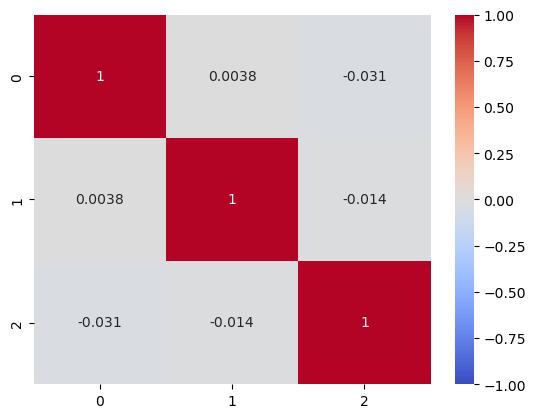

In [87]:
sim_results_per_asset = []

for asset_sim in mc_simed_ret_assets:
    # asset_sim shape: (1000, 14) -> Daily Log Returns
    
    # รวม Log Return 14 วัน เป็นก้อนเดียว (Total Log Return)
    # axis=1 คือรวมตามแกนเวลา (Time)
    total_return = np.sum(asset_sim, axis=1) # ได้ shape (1000,)
    
    sim_results_per_asset.append(total_return)

# 2. แปลงเป็น Matrix (Num_Assets, Num_Sims)
# เช่น (3, 1000)
comparison_matrix = np.array(sim_results_per_asset)

# 3. คำนวณ Correlation Matrix
corr_matrix = np.corrcoef(comparison_matrix)

print("Correlation Matrix:")
print(corr_matrix)

# (แถม) วาด Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

## Experiment

### Ground Truth Stats

In [88]:
x_test = next(iter(test_loader))
x_test_sampling = x_test[2, :, :, :]
x_test_sampling.shape

torch.Size([64, 3, 2])

In [89]:
x_test_sampling_np = x_test_sampling.cpu().numpy()
print(type(x_test_sampling))
print(type(x_test_sampling_np))

<class 'torch.Tensor'>
<class 'numpy.ndarray'>


In [90]:
def calc_stats(x):
    if x.ndim == 2:
        # Shape: [64, 3] -> [L, N]
        print(x.shape)
        mean = np.mean(x, axis=0)
        std = np.std(x, axis=0)
        avg_corr = np.corrcoef(x.T)

    # Calc All na
    if x.ndim == 3:
        # Shape: (1000, 64, 3) -> [Num of sims, L, N]
        mean = np.mean(x, axis=(0, 1))
        std = np.std(x, axis=(0, 1))

        corrs = []
        for i in range(x.shape[0]):
            c_mat = np.corrcoef(x[i].T)
            corrs.append(c_mat)

        avg_corr = np.mean(corrs,axis=0)
    return mean, std, avg_corr

In [91]:
gt_mean, gt_std, gt_corr = calc_stats(x_test_sampling_np[:,:,-1])

(64, 3)


In [92]:
gt_corr

array([[1.        , 0.22431608, 0.41732777],
       [0.22431608, 1.        , 0.02566512],
       [0.41732777, 0.02566512, 1.        ]])

In [93]:
print("--- Ground Truth Stats ---")
print(f"Mean: {gt_mean}")
print(f"Std:  {gt_std}")
print(f"Corr Matrix:\n{gt_corr}")
print("-" * 30)

--- Ground Truth Stats ---
Mean: [-0.03157155 -0.03290484 -0.03535237]
Std:  [0.18766466 0.19381005 0.17001379]
Corr Matrix:
[[1.         0.22431608 0.41732777]
 [0.22431608 1.         0.02566512]
 [0.41732777 0.02566512 1.        ]]
------------------------------


### MC Stats

In [94]:
length , num_assets, num_features = x_test_sampling.shape

# Config
SPLIT_IDX = 60
STEPS_SIMS = 4
NUM_SIMS = 1000


In [95]:
x_test_sampling.shape

torch.Size([64, 3, 2])

In [96]:
y = x_test_sampling[-4:]
y.shape

torch.Size([4, 3, 2])

In [97]:
context_data = x_test_sampling[:SPLIT_IDX, :]
context_data.shape

torch.Size([60, 3, 2])

In [98]:
mc_sims_paths = []
for i in range(num_assets):
    print("---" * 30)
    asset_context = context_data[:, i][:, 0]
    print(f"Shape: {asset_context.shape}")
    mc_pred_returns = gbm_monte_carlo_simulate(
        hist_log_returns=asset_context.cpu().numpy(), 
        steps_to_predict=STEPS_SIMS, 
        num_sims=NUM_SIMS
    )
    print(f"MC Pred Returns Shape: {mc_pred_returns.shape}")
    
    context_expanded = np.tile(asset_context.cpu(), (NUM_SIMS, 1))
    print(f"Context Expanded Shape: {context_expanded.shape}")
    
    full_paths = np.hstack([context_expanded, mc_pred_returns])
    print(f"Full Paths Shape: {full_paths.shape}")
    mc_sims_paths.append(full_paths)

------------------------------------------------------------------------------------------
Shape: torch.Size([60])
MC Pred Returns Shape: (1000, 4)
Context Expanded Shape: (1000, 60)
Full Paths Shape: (1000, 64)
------------------------------------------------------------------------------------------
Shape: torch.Size([60])
MC Pred Returns Shape: (1000, 4)
Context Expanded Shape: (1000, 60)
Full Paths Shape: (1000, 64)
------------------------------------------------------------------------------------------
Shape: torch.Size([60])
MC Pred Returns Shape: (1000, 4)
Context Expanded Shape: (1000, 60)
Full Paths Shape: (1000, 64)


#### Inside detail in the loop

In [99]:
mc_pred_returns = gbm_monte_carlo_simulate(
    hist_log_returns=asset_context.cpu().numpy(), 
    steps_to_predict=STEPS_SIMS, 
    num_sims=NUM_SIMS
)
mc_pred_returns.shape

(1000, 4)

In [100]:
context_expanded = np.tile(asset_context.cpu(), (NUM_SIMS, 1))
context_expanded.shape

(1000, 60)

In [101]:
full_paths = np.hstack([context_expanded, mc_pred_returns])
full_paths.shape

(1000, 64)

#### MC Stats Calc

In [102]:
mc_sims_paths[0].shape

(1000, 64)

In [103]:
mc_sims = np.stack(mc_sims_paths, axis=-1)
mc_sims.shape

(1000, 64, 3)

In [104]:
type(mc_sims)

numpy.ndarray

In [105]:
mc_sims_mean, mc_sims_std, mc_sims_corr = calc_stats(mc_sims)

In [106]:
print("--- MC Stats ---")
print(f"Mean: {mc_sims_mean}")
print(f"Std:  {mc_sims_std}")
print(f"Corr Matrix:\n{mc_sims_corr}")
print("-" * 30)

--- MC Stats ---
Mean: [0.07587531 0.07617761 0.07970697]
Std:  [0.05382338 0.11291362 0.04580671]
Corr Matrix:
[[1.         0.33641671 0.62017901]
 [0.33641671 1.         0.32760607]
 [0.62017901 0.32760607 1.        ]]
------------------------------


## MC (GenAI) Stats

In [107]:
# x_test_sampling = x_test[0].unsqueeze(0)
x_test_sampling.shape

torch.Size([64, 3, 2])

In [108]:
length , num_assets, num_features = x_test_sampling.shape

# Config
SPLIT_IDX = 60
STEPS_SIMS = 4
NUM_SIMS = 1000


In [109]:
mc_genai_y = x_test_sampling[-4:]
mc_genai_y.shape

torch.Size([4, 3, 2])

In [110]:
mc_genai_context_x = x_test_sampling[:SPLIT_IDX, :]
mc_genai_context_x.shape

torch.Size([60, 3, 2])

In [111]:
mc_genai_context_x = mc_genai_context_x.unsqueeze(0)
mc_genai_context_x.shape

torch.Size([1, 60, 3, 2])

In [112]:
# Shape requires [1, 64, 3, 2]
mc_y = monte_carlo_simulate(context_data=mc_genai_context_x, steps_to_simulate=STEPS_SIMS, engine=engine,num_simulations=NUM_SIMS)
mc_y.shape # [Sims, Time, Assets, Features]

INFO:engine.trainer:Simulating... (Masking last 4 steps)
In-painting: 1000it [00:34, 28.67it/s]


(1000, 60, 3, 2)

In [113]:
# Shape require for calc stats is (1000, 64, 3)
mc_genai_y = mc_y[:,:,:,0]
mc_genai_y.shape

(1000, 60, 3)

In [114]:
mc_genai_mean, mc_genai_std, mc_genai_corr = calc_stats(mc_genai_y)
print("--- MC GenAI Stats ---")
print(f"Mean: {mc_genai_mean}")
print(f"Std:  {mc_genai_std}")
print(f"Corr Matrix:\n{mc_genai_corr}")
print("-" * 30)

--- MC GenAI Stats ---
Mean: [0.07491504 0.07685572 0.07835328]
Std:  [0.05516447 0.1147346  0.04667184]
Corr Matrix:
[[1.         0.37462521 0.65891509]
 [0.37462521 1.         0.36678183]
 [0.65891509 0.36678183 1.        ]]
------------------------------


In [115]:
mc_genai_corr, mc_sims_corr, gt_corr


(array([[1.        , 0.37462521, 0.65891509],
        [0.37462521, 1.        , 0.36678183],
        [0.65891509, 0.36678183, 1.        ]]),
 array([[1.        , 0.33641671, 0.62017901],
        [0.33641671, 1.        , 0.32760607],
        [0.62017901, 0.32760607, 1.        ]]),
 array([[1.        , 0.22431608, 0.41732777],
        [0.22431608, 1.        , 0.02566512],
        [0.41732777, 0.02566512, 1.        ]]))